# Imports

In [1]:
import os
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
from pathlib import Path
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

2025-05-10 04:03:57.847972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746849838.045551    2487 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746849838.111240    2487 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746849838.603599    2487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746849838.603649    2487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746849838.603651    2487 computation_placer.cc:177] computation placer alr

# Setting CPU cores

In [2]:
# Tensorflow Configuration
import multiprocessing

# Get the total number of CPU cores available
total_cores = multiprocessing.cpu_count()

# Calculate 75% of available cores (rounded down)
cores_to_use = int(total_cores * 0.90)

# Ensure at least 1 core is used
cores_to_use = max(1, cores_to_use)

# Set the environment variable
os.environ["LOKY_MAX_CPU_COUNT"] = str(cores_to_use)

print(f"Using {cores_to_use} out of {total_cores} available CPU cores (75%)")

# Add after TensorFlow import
tf.config.threading.set_inter_op_parallelism_threads(cores_to_use // 2)
tf.config.threading.set_intra_op_parallelism_threads(cores_to_use // 2)

Using 14 out of 16 available CPU cores (75%)


# Data Settings

In [3]:
# All bird species available in the HDF5 spectrogram dataset
ALL_BIRD_SPECIES = [
    'amecro',  # American Crow
    'amerob',  # American Robin
    'bewwre',  # Bewick's Wren
    'bkcchi',  # Black-capped Chickadee
    'daejun',  # Dark-eyed Junco
    'houfin',  # House Finch
    'houspa',  # House Sparrow
    'norfli',  # Northern Flicker
    'rewbla',  # Red-winged Blackbird
    'sonspa',  # Song Sparrow
    'spotow',  # Spotted Towhee
    'whcspa',  # White-crowned Sparrow
]

# Path to the HDF5 file containing bird spectrograms
SPEC_FILE_PATH = Path('../data/bird_spectrograms.hdf5')

# Training hyperparameters
EPOCHS = 50                 # Total number of training epochs
NUM_CV_FOLDS = 3            # K-Fold cross-validation (choose 3, 4, or 5)
BATCH_SIZE = [64, 128, 32]           # Batch size for training
LEARNING_RATE = [0.0005, 0.001]      # Learning rate for the optimizer

# List of evaluation metrics
EVALUATION_METRICS = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Data Shape Preparation for TensorFlow

Before feeding the bird spectrograms into the CNN, we need to ensure that input tensor shape matches what TensorFlow expects:

**Original shape:**  
`(128, 517, sample_size)` → This format isn't compatible with TensorFlow's input standard.

**Required shape:**  
`(sample_size, 128, 517, 1)`  
This format follows the convention:  
- `N`: Number of samples (segments)  
- `H`: Height of the image (128 Mel bands)  
- `W`: Width (517 time steps)  
- `C`: Channels (1 for grayscale spectrograms)

This transformation is achieved using:
```python
X = np.expand_dims(X, axis=-1)


In [4]:
X = []
y = []

num_classes = 0

with h5py.File(SPEC_FILE_PATH, 'r') as f:
    for label, key in enumerate(f.keys()):
        data = f[key][:]  # shape = (128, 517, N)
        data = np.transpose(data, (2, 0, 1))  # shape = (N, 128, 517)
        X.append(data)
        y.append(np.full((data.shape[0],), label, dtype=np.int32))
        num_classes += 1

X = np.concatenate(X, axis=0)  # (N_total, 128, 517)
y = np.concatenate(y)          # (N_total,)

X = np.expand_dims(X, axis=-1)  # (N_total, 128, 517, 1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(num_classes)

X shape: (1981, 128, 517, 1)
y shape: (1981,)
12


# CNN Model Model Architecture

This convolutional neural network (CNN) performs **binary classification** on spectrogram inputs of shape `(1, 128, 517)`, where:
- `1` is the channel dimension (grayscale),
- `128` is the number of frequency bins (height),
- `517` is the number of time steps (width).

Note: TensorFlow expects input shape (N, H, W, C) at training time, so during data preparation, I reshaped it to (N, 128, 517, 1).

---

### 1. General Steps for CNN
According to a very long discussion on the order of layers, BN, DropOut, and Pooling on [stackoverflow](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) <br>
Generally, this laying is the consensus. <br>

`Conv → BatchNorm → ReLU → Dropout → MaxPool`

### 2. After Global Average Pooling
After applying a Global Average Pooling layer to flatten the spatial feature maps, an additional Dense layer with BatchNorm and Dropout was included. It introduces non-linear combinations of the extracted features, allowing richer interactions.

# CNN Model #1

In [ ]:
def five_layer_cnn(num_classes, input_shape=(128, 517, 1), dropout_rate=0.3, learning_rate=0.0005):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(128, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(512, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def four_layer_cnn(num_classes, input_shape=(128, 517, 1), dropout_rate=0.2, learning_rate=0.0001):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
    
    return model

# Graph Plotting

In [6]:
def build_plot_training_history(history, path, tag):
    """
    Plots training and validation accuracy and loss from two training histories.

    Args:
        history: First training history object.
        history2: Second training history object.
    """
    # Extract values from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{path}/{tag}_acc.png')
    plt.show()
    plt.close()

    # Plot Loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{path}/{tag}_loss.png')
    plt.show()
    plt.close()

def plot_cm(cm, path, tag):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f"Class {i}" for i in range(num_classes)],
                yticklabels=[f"Class {i}" for i in range(num_classes)])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f"{path}/{tag}_confusion_matrix.png")
    plt.close()

## Model Training and Evaluation (Multi-Class)

After testing various CNN depths in the binary classification setting, the **larger models** consistently performed better. Based on that observation, I adopted a **4 & 5-layer CNN** for the multi-class setup.

---

### Dataset Split & Distribution

I used an 80/20 stratified split to ensure the class distribution remains balanced across train and test sets. This is especially important for multi-class tasks and data-preprocess let me know that the bird data is imbalanced.

# 5 Layer Model Run
- Batch Size = 64
- Dropout = 0.3
- Learning Rate = 0.0005
- 50 EPOCHS with early stopping.

Train class distribution: [ 53 137 115  36 100  67 504  30 149 210 110  73]
Test class distribution: [ 13  35  29   9  25  17 126   7  38  53  27  18]
(128, 517, 1)


2025-05-09 03:43:23.144215: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 252s 10s/step - accuracy: 0.2573 - loss: 2.3555 - val_accuracy: 0.1360 - val_loss: 2.3288 - learning_rate: 5.0000e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 245s 10s/step - accuracy: 0.3070 - loss: 2.2001 - val_accuracy: 0.1310 - val_loss: 2.4065 - learning_rate: 5.0000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 243s 10s/step - accuracy: 0.3261 - loss: 2.1492 - val_accuracy: 0.1436 - val_loss: 2.4572 - learning_rate: 5.0000e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 243s 10s/step - accuracy: 0.3128 - loss: 2.1671 - val_accuracy: 0.1486 - val_loss: 2.4023 - learning_rate: 5.0000e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 244s 10s/step - accuracy: 0.3116 - loss: 2.1181 - val_accuracy: 0.2343 - val_loss: 2.3122 - learning_rate: 5.0000e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 242s 10s/step - accuracy: 0.3528 - loss: 2.0296 - val_accuracy: 0.3149 - val_loss: 3.6149 - learning_rate: 5.0000e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 242s 10s/step - accuracy: 

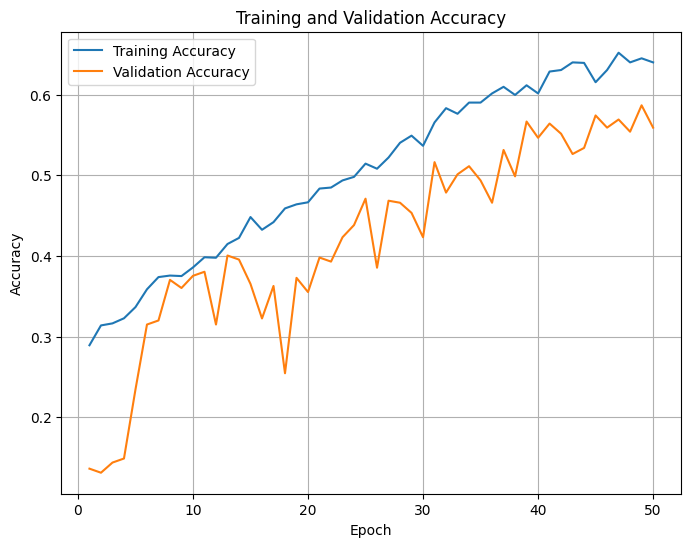

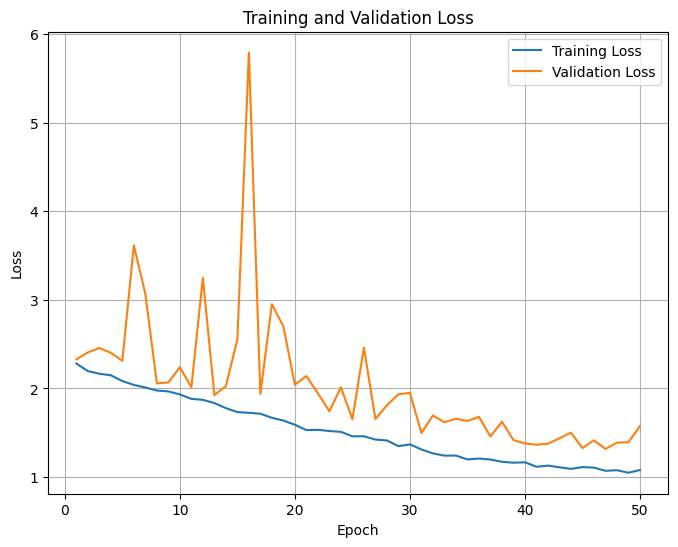

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Confusion Matrix:
 [[  9   0   0   0   0   0   2   0   1   1   0   0]
 [  0  13   0   0   0   1   5   0   8   3   2   3]
 [  1   2   4   0   2   0   2   0   2  11   5   0]
 [  0   1   0   0   0   0   3   0   4   1   0   0]
 [  3   1   0   0  13   0   2   0   0   2   2   2]
 [  0   3   1   0   1   3   0   0   4   5   0   0]
 [  2   1   0   0   0   0 115   0   4   1   3   0]
 [  1   0   0   0   1   0   0   0   4   1   0   0]
 [  1   2   0   0   1   0   5   0  19   4   5   1]
 [  1   2   3   0   2   0   5   0   4  33   2   1]
 [  0   0   0   0   0   0   5   0   5   4  13   0]
 [  0   1   0   0   3   0   1   0   2   6   1   4]]
Confusion matrix saved to ../output/multi-class_results/5_layer_best_model_results_confusion_matrix.csv


/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.6923    0.5806        13
           1     0.5000    0.3714    0.4262        35
           2     0.5000    0.1379    0.2162        29
           3     0.0000    0.0000    0.0000         9
           4     0.5652    0.5200    0.5417        25
           5     0.7500    0.1765    0.2857        17
           6     0.7931    0.9127    0.8487       126
           7     0.0000    0.0000    0.0000         7
           8     0.3333    0.5000    0.4000        38
           9     0.4583    0.6226    0.5280        53
          10     0.3939    0.4815    0.4333        27
          11     0.3636    0.2222    0.2759        18

    accuracy                         0.5693       397
   macro avg     0.4298    0.3864    0.3780       397
weighted avg     0.5528    0.5693    0.5388       397



,accuracy,precision_macro,recall_macro,f1_macro
5_layer_best_model_results,0.56927,0.429797,0.386432,0.378031


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, shuffle=True
)

print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))
print(X_train.shape[1:])
# Initialize model
model = five_layer_cnn(num_classes=num_classes, input_shape=X_train.shape[1:], dropout_rate=0.3, learning_rate=0.0005)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train
history_5layer = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualize training history (optional)
result_path = "../output/multi-class_results"
run_tag = f"5_layer_best_model_results"
build_plot_training_history(history_5layer, result_path, run_tag)

# Evaluate
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = y_test.flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Save raw confusion matrix values
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(num_classes)],
                         columns=[f"Predicted_{i}" for i in range(num_classes)])

cm_csv_path = f"{result_path}/{run_tag}_confusion_matrix.csv"
cm_df.to_csv(cm_csv_path)
print(f"Confusion matrix saved to {cm_csv_path}")

plot_cm(cm, result_path, run_tag)

# Classification Report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Save results
metrics = pd.DataFrame(columns=EVALUATION_METRICS)
metrics.loc[run_tag] = [acc, prec, rec, f1]

# Cleanup
K.clear_session()
del model
gc.collect()

display(metrics)

# 4 Layer Model Run
- Batch Size = 32
- Dropout = 0.2
- Learning Rate = 0.0005
- 50 EPOCHS with early stopping.

Train class distribution: [ 53 137 115  36 100  67 504  30 149 210 110  73]
Test class distribution: [ 13  35  29   9  25  17 126   7  38  53  27  18]
(128, 517, 1)


2025-05-10 04:04:40.350111: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.1421 - loss: 2.7753 - val_accuracy: 0.0705 - val_loss: 2.9484 - learning_rate: 5.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.2498 - loss: 2.4021 - val_accuracy: 0.3073 - val_loss: 2.3833 - learning_rate: 5.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.2906 - loss: 2.2473 - val_accuracy: 0.3476 - val_loss: 2.2462 - learning_rate: 5.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3720 - loss: 2.0047 - val_accuracy: 0.3300 - val_loss: 2.2740 - learning_rate: 5.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.3918 - loss: 1.9770 - val_accuracy: 0.3451 - val_loss: 2.1341 - learning_rate: 5.0000e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.3850 - loss: 1.8554 - val_accuracy: 0.2796 - val_loss: 2.2325 - learning_rate: 5.0000e-04
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.4106 

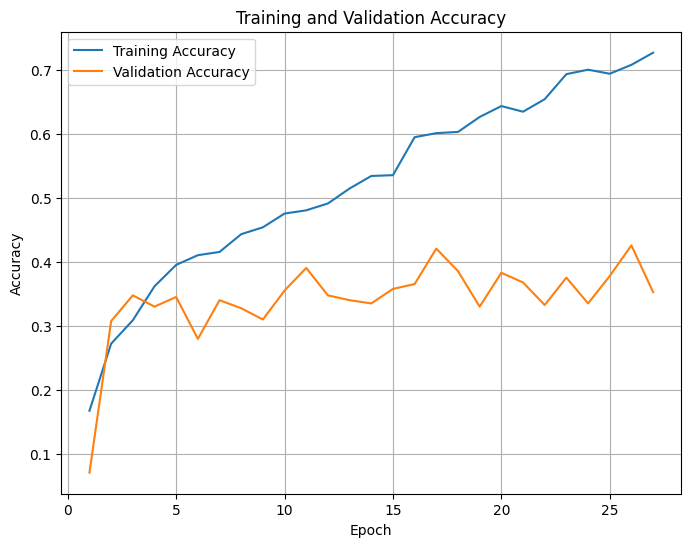

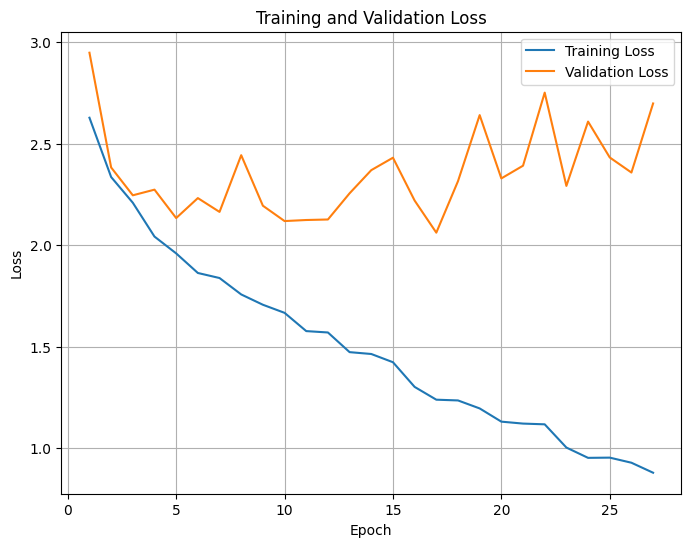

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step
Confusion Matrix:
 [[  0   0   0   0   0   0   8   0   0   3   2   0]
 [  0   0   0   0   0   0  12   0   2  10  11   0]
 [  0   0   0   0   1   0   7   0   0  13   8   0]
 [  0   0   0   0   0   0   2   0   0   6   1   0]
 [  0   0   0   0   5   0   4   0   0   7   9   0]
 [  0   0   0   0   0   0   5   0   0   6   6   0]
 [  0   0   0   0   0   0 107   0   0   5  14   0]
 [  0   0   0   0   0   0   1   0   0   2   4   0]
 [  0   0   0   0   0   0   9   0   3  10  16   0]
 [  0   0   0   0   1   0   7   0   0  34  11   0]
 [  0   0   0   0   0   0   4   0   0   5  18   0]
 [  0   0   0   0   1   0   1   0   0   7   9   0]]
Confusion matrix saved to ../output/multi-class_results/4_layer_best_model_results_confusion_matrix.csv


/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        13
           1     0.0000    0.0000    0.0000        35
           2     0.0000    0.0000    0.0000        29
           3     0.0000    0.0000    0.0000         9
           4     0.6250    0.2000    0.3030        25
           5     0.0000    0.0000    0.0000        17
           6     0.6407    0.8492    0.7304       126
           7     0.0000    0.0000    0.0000         7
           8     0.6000    0.0789    0.1395        38
           9     0.3148    0.6415    0.4224        53
          10     0.1651    0.6667    0.2647        27
          11     0.0000    0.0000    0.0000        18

    accuracy                         0.4207       397
   macro avg     0.1955    0.2030    0.1550       397
weighted avg     0.3534    0.4207    0.3386       397



,accuracy,precision_macro,recall_macro,f1_macro
4_layer_best_model_results,0.420655,0.195473,0.203027,0.155001


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, shuffle=True
)

print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))
print(X_train.shape[1:])
# Initialize model
model = four_layer_cnn(num_classes=num_classes, input_shape=X_train.shape[1:], dropout_rate=0.2, learning_rate=0.0005)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train
history_4layer = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualize training history (optional)
result_path = "../output/multi-class_results"
run_tag = f"4_layer_best_model_results"
build_plot_training_history(history_4layer, result_path, run_tag)
model.save(f'{result_path}/{run_tag}.keras')

# Evaluate
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = y_test.flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Save raw confusion matrix values
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(num_classes)],
                         columns=[f"Predicted_{i}" for i in range(num_classes)])

cm_csv_path = f"{result_path}/{run_tag}_confusion_matrix.csv"
cm_df.to_csv(cm_csv_path)
print(f"Confusion matrix saved to {cm_csv_path}")

plot_cm(cm, result_path, run_tag)

# Classification Report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Save results
metrics = pd.DataFrame(columns=EVALUATION_METRICS)
metrics.loc[run_tag] = [acc, prec, rec, f1]

# Cleanup
K.clear_session()
del model
gc.collect()

display(metrics)

# 5 Layer Model Run (Longer Epochs)

- Batch Size = 64
- Dropout = 0.3
- Learning Rate = 0.0005
- 300 EPOCHS with early stopping.

Train class distribution: [ 53 137 115  36 100  67 504  30 149 210 110  73]
Test class distribution: [ 13  35  29   9  25  17 126   7  38  53  27  18]
(128, 517, 1)
Epoch 1/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 247s 10s/step - accuracy: 0.2169 - loss: 2.4085 - val_accuracy: 0.3174 - val_loss: 2.3214 - learning_rate: 5.0000e-04
Epoch 2/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 244s 10s/step - accuracy: 0.3104 - loss: 2.1953 - val_accuracy: 0.3174 - val_loss: 2.3054 - learning_rate: 5.0000e-04
Epoch 3/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 243s 10s/step - accuracy: 0.3018 - loss: 2.1926 - val_accuracy: 0.3023 - val_loss: 2.3125 - learning_rate: 5.0000e-04
Epoch 4/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 243s 10s/step - accuracy: 0.3446 - loss: 2.0855 - val_accuracy: 0.2670 - val_loss: 2.2518 - learning_rate: 5.0000e-04
Epoch 5/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 242s 10s/step - accuracy: 0.3614 - loss: 2.0288 - val_accuracy: 0.2292 - val_loss: 2.3148 - learning_rate: 5.0000e-04
Epoch 6/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 237s 9s/ste

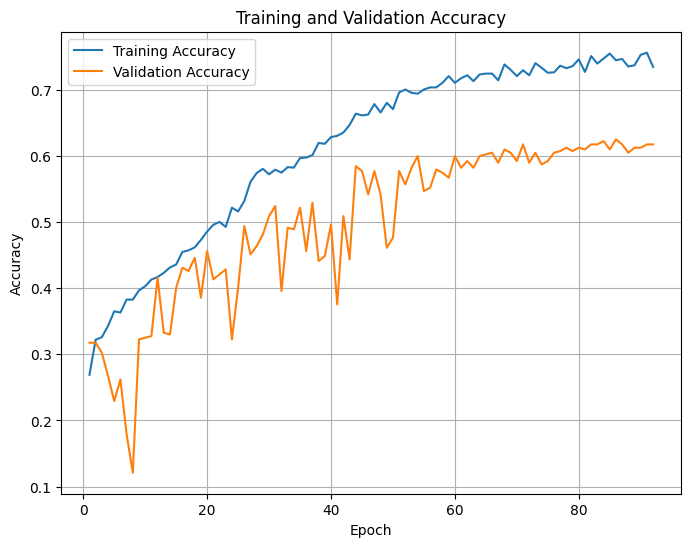

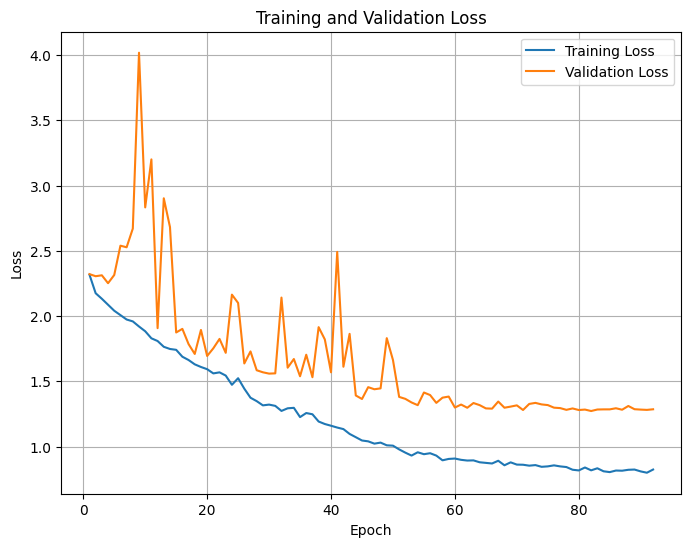

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Confusion Matrix:
 [[  9   0   0   0   1   0   1   0   1   0   1   0]
 [  1  25   1   0   0   0   2   0   4   1   1   0]
 [  0   0  11   0   0   1   0   0   2   6   9   0]
 [  0   0   1   0   0   0   0   0   2   4   0   2]
 [  0   0   2   1  16   0   0   0   1   1   1   3]
 [  0   3   1   0   0   4   4   0   1   3   0   1]
 [  3   4   1   0   0   1 111   0   4   1   1   0]
 [  0   3   0   0   0   0   1   0   2   0   1   0]
 [  1   3   0   1   0   0   2   0  26   4   0   1]
 [  1   4   2   0   2   0   2   0   7  29   6   0]
 [  3   2   0   1   1   0   5   0   2   4   8   1]
 [  0   4   0   1   1   0   2   0   1   1   2   6]]
Confusion matrix saved to ../output/multi-class_results/5_layer_longer_epochs_best_model_results_confusion_matrix.csv


/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/exouser/DATA-5322/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.6923    0.5806        13
           1     0.5208    0.7143    0.6024        35
           2     0.5789    0.3793    0.4583        29
           3     0.0000    0.0000    0.0000         9
           4     0.7619    0.6400    0.6957        25
           5     0.6667    0.2353    0.3478        17
           6     0.8538    0.8810    0.8672       126
           7     0.0000    0.0000    0.0000         7
           8     0.4906    0.6842    0.5714        38
           9     0.5370    0.5472    0.5421        53
          10     0.2667    0.2963    0.2807        27
          11     0.4286    0.3333    0.3750        18

    accuracy                         0.6171       397
   macro avg     0.4671    0.4503    0.4434       397
weighted avg     0.6083    0.6171    0.6027       397



,accuracy,precision_macro,recall_macro,f1_macro
5_layer_longer_epochs_best_model_results,0.617128,0.467087,0.450263,0.443437


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, shuffle=True
)

print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))
print(X_train.shape[1:])
# Initialize model
model = five_layer_cnn(num_classes=num_classes, input_shape=X_train.shape[1:], dropout_rate=0.3, learning_rate=0.0005)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train
history_5layer = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=300,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualize training history (optional)
result_path = "../output/multi-class_results"
run_tag = f"5_layer_longer_epochs_best_model_results"
build_plot_training_history(history_5layer, result_path, run_tag)
model.save(f'{result_path}/{run_tag}.keras')

# Evaluate
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = y_test.flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Save raw confusion matrix values
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(num_classes)],
                         columns=[f"Predicted_{i}" for i in range(num_classes)])

cm_csv_path = f"{result_path}/{run_tag}_confusion_matrix.csv"
cm_df.to_csv(cm_csv_path)
print(f"Confusion matrix saved to {cm_csv_path}")

plot_cm(cm, result_path, run_tag)

# Classification Report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Save results
metrics = pd.DataFrame(columns=EVALUATION_METRICS)
metrics.loc[run_tag] = [acc, prec, rec, f1]

# Cleanup
K.clear_session()
del model
gc.collect()

display(metrics)

# TL;DR

5 layer model that was run on for longer epochs gave the best results.

- All results for the multi-class is saved in multi-class results folder in the output directory.